In [ ]:
!pip install gym


In [2]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython import display


In [10]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, exploration_prob=1.0, exploration_decay=0.99, num_bins=30):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob
        self.exploration_decay = exploration_decay
        self.num_bins = num_bins
        self.state_space_bins = [np.linspace(self.env.observation_space.low[i], self.env.observation_space.high[i], num=num_bins - 1) for i in range(self.env.observation_space.shape[0])]
        self.action_space_size = self.env.action_space.n
        self.q_table = np.random.uniform(low=-1, high=1, size=([num_bins] * self.env.observation_space.shape[0] + [self.action_space_size]))

    def preprocess_state(self, state):
        state_idx = tuple(np.digitize(state[i], self.state_space_bins[i]) for i in range(self.env.observation_space.shape[0]))
        return state_idx

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_prob:
            return self.env.action_space.sample()
        else:
            state_idx = self.preprocess_state(state)
            q_values = self.q_table[state_idx]
            return np.argmax(q_values)

    def update_q_table(self, state, action, reward, next_state):
        state_idx = self.preprocess_state(state)
        next_state_idx = self.preprocess_state(next_state)
        current_q = self.q_table[state_idx + (action,)]
        max_next_q = np.max(self.q_table[next_state_idx])
        new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (reward + self.discount_factor * max_next_q)
        self.q_table[state_idx + (action,)] = new_q

    def train(self, num_episodes=1000):
        for episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                total_reward += reward

                self.update_q_table(state, action, reward, next_state)

                state = next_state

                if done:
                    break

            # Exploration probability decay after each episode
            self.exploration_prob *= self.exploration_decay


In [29]:
# Create environment
env = gym.make('CartPole-v1')

# Initialize Q-Learning-Agent
agent = QLearningAgent(env)

# Agent Training
agent.train(num_episodes=10000)

# Testing
total_rewards = []
num_test_episodes = 10

for _ in range(num_test_episodes):
    state = env.reset()
    total_reward = 0

    while True:
        action = agent.choose_action(state)
        state, reward, done, _ = env.step(action)
        total_reward += reward

        if done:
            break

    total_rewards.append(total_reward)

average_reward = sum(total_rewards) / num_test_episodes
print("Durchschnittliche Belohnung über", num_test_episodes, "Testepisoden:", average_reward)

# Speichere den Agenten (Q-Table) für zukünftige Verwendung
np.save('q_table.npy', agent.q_table)


Durchschnittliche Belohnung über 10 Testepisoden: 30.4


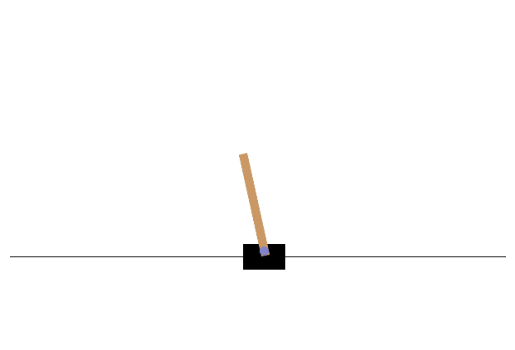

In [31]:
# Create environment
env = gym.make('CartPole-v1')

# Load trained Agent
agent = QLearningAgent(env)
agent.q_table = np.load('q_table.npy')

# Visualize Agent in environment
def visualize_agent(agent, env):
    state = env.reset()
    done = False

    while not done:
        action = agent.choose_action(state)
        next_state, _, done, _ = env.step(action)

        # Show Play
        plt.imshow(env.render(mode='rgb_array'))
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)

        state = next_state


num_test_episodes = 5

for _ in range(num_test_episodes):
    visualize_agent(agent, env)

env.close()


In [32]:
# Average reward calculatoin function
def evaluate_agent(agent, env, num_episodes):
    total_rewards = []

    for _ in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.choose_action(state)
            state, reward, done, _ = env.step(action)
            total_reward += reward

        total_rewards.append(total_reward)

    average_reward = np.mean(total_rewards)
    return average_reward

# Evaluate Agent
num_evaluation_episodes = 1000
average_reward = evaluate_agent(agent, env, num_evaluation_episodes)
print("Durchschnittliche Belohnung über", num_evaluation_episodes, "Testepisoden:", average_reward)

env.close()


Durchschnittliche Belohnung über 1000 Testepisoden: 22.493


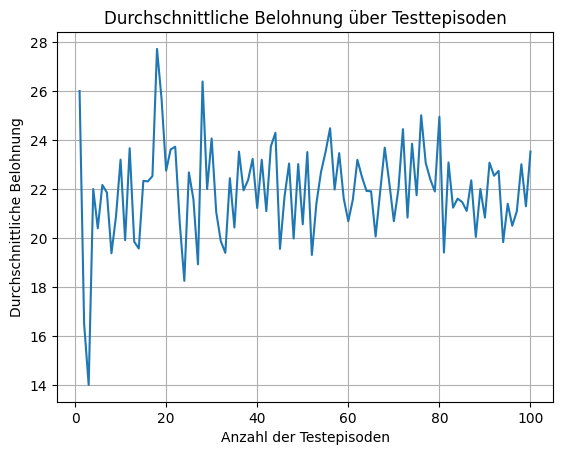

In [38]:
# Plot Evaluation
num_evaluation_episodes = 100
average_rewards = []

for i in range(num_evaluation_episodes):
    average_reward = evaluate_agent(agent, env, i + 1)
    average_rewards.append(average_reward)


plt.plot(range(1, num_evaluation_episodes + 1), average_rewards)
plt.xlabel('Anzahl der Testepisoden')
plt.ylabel('Durchschnittliche Belohnung')
plt.title('Durchschnittliche Belohnung über Testtepisoden')
plt.grid(True)
plt.show()

env.close()
